In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('paper')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_context('talk')
sns.set_style('white')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['X', 'P', 's', 'D', 'o']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
os.listdir('fcmfiles')

['fcmfiles.zip',
 'FCM_exp1_100Days.csv',
 'FCM_exp1_140Days.csv',
 'FCM_exp1_60Days.csv',
 'FCM_exp3_140Days.csv',
 'FCM_exp4_140Days.csv']

In [9]:
dflist=list()
for i in os.listdir('fcmfiles'):
    if i.endswith('.csv'):
        d = pd.read_csv(os.path.join('fcmfiles', i))
        n = os.path.splitext(i)[0]
        _, experiment, day = n.split('_')
        d['experiment'] = experiment
        d['day'] = day.replace('Days','')
        dflist.append(d)
df = pd.concat(dflist)
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [10]:
df.head()

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100


In [11]:
for c in df.columns:
    if c in ['PRO.1', 'ALT.1']:
        continue
    print(c, df[c].unique())

PRO ['MED4' 'MIT9313' 'MIT9312' 'Natl2A' 'MIT0604' nan]
ALT ['1A3' 'DE' 'DE1' 'BS11' 'ATCC' nan]
sample ['1A' '1B' '1C' '2A' '2B' '2C' '3A' '3B' '3C' '4A' '4B' '4C' '5A' '5B'
 '5C' '6A' '6B' '6C' '7A' '7B' '7C' '8A' '8B' '8C' '9A' '9B' '9C' '10A'
 '10B' '10C' '11A' '11B' '11C' '12A' '12B' '12C' '13A' '13B' '13C' '14A'
 '14B' '14C' '15A' '15B' '15C' '16A' '16B' '16C' '17A' '17B' '17C' '18A'
 '18B' '18C' '19A' '19B' '19C' '20A' '20B' '20C' '21A' '21B' '21C' '22A'
 '22B' '22C' '23A' '23B' '23C' '24A' '24B' '24C' '25A' '25B' '25C' '26A'
 '26B' '26C' '27A' '27B' '27C' '28A' '28B' '28C' '29A' '29B' '29C' '30A'
 '30B' '30C' '31A' '31B' '31C' '32A' '32B' '32C' '33A' '33B' '33C' '34A'
 '34B' '34C' '35A' '35B' '35C']
experiment ['exp1' 'exp3' 'exp4']
day ['100' '140' '60']


In [12]:
df.dtypes

PRO            object
ALT            object
sample         object
PRO.1         float64
ALT.1         float64
experiment     object
day            object
dtype: object

In [13]:
df['day'] = pd.to_numeric(df['day'])

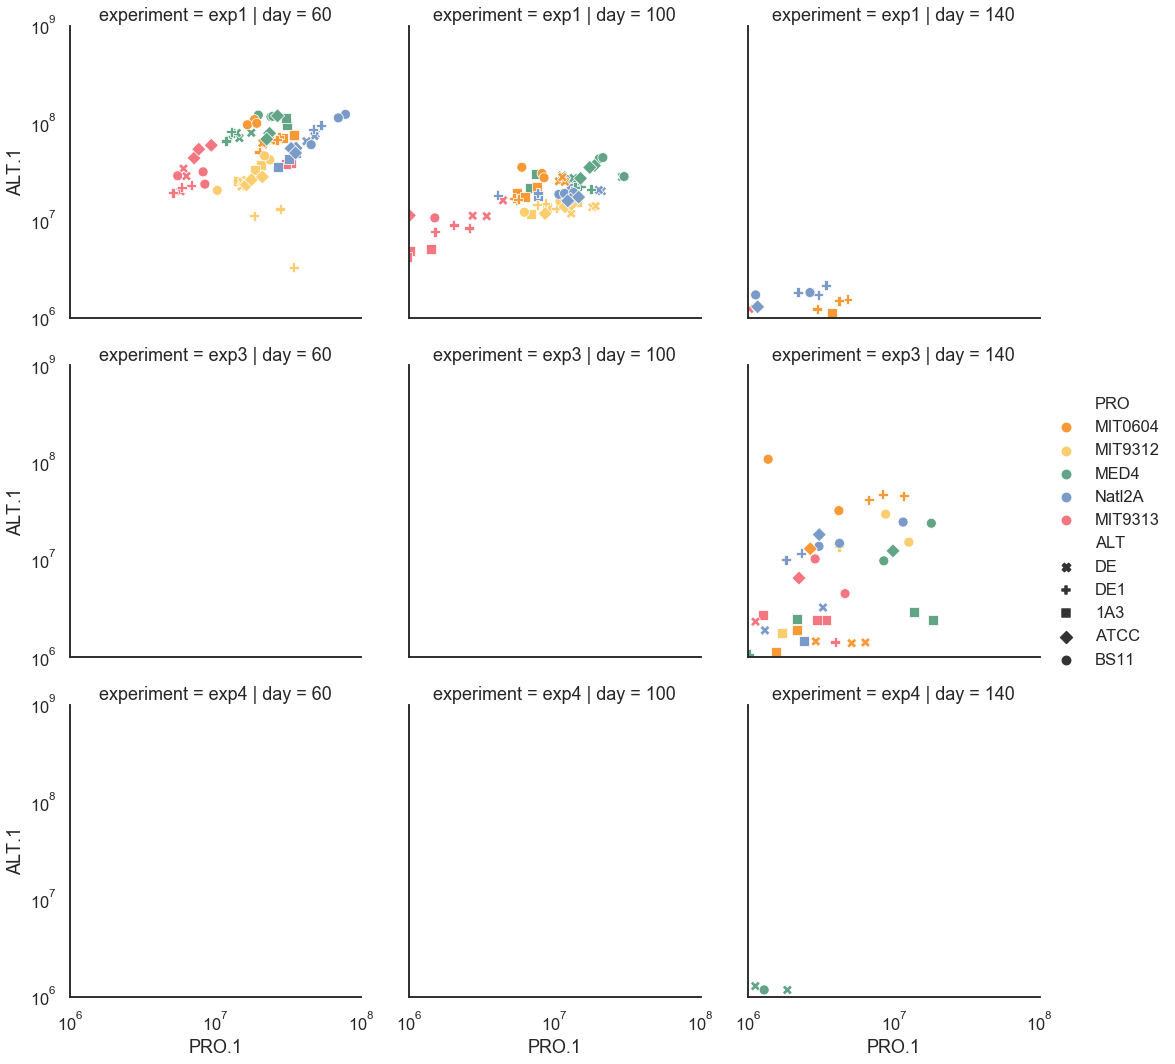

In [14]:
g= sns.relplot(data=df, x='PRO.1', y='ALT.1', col='day', row='experiment', hue='PRO', style='ALT', s=100,
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
           )
g.set(yscale='log')
g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

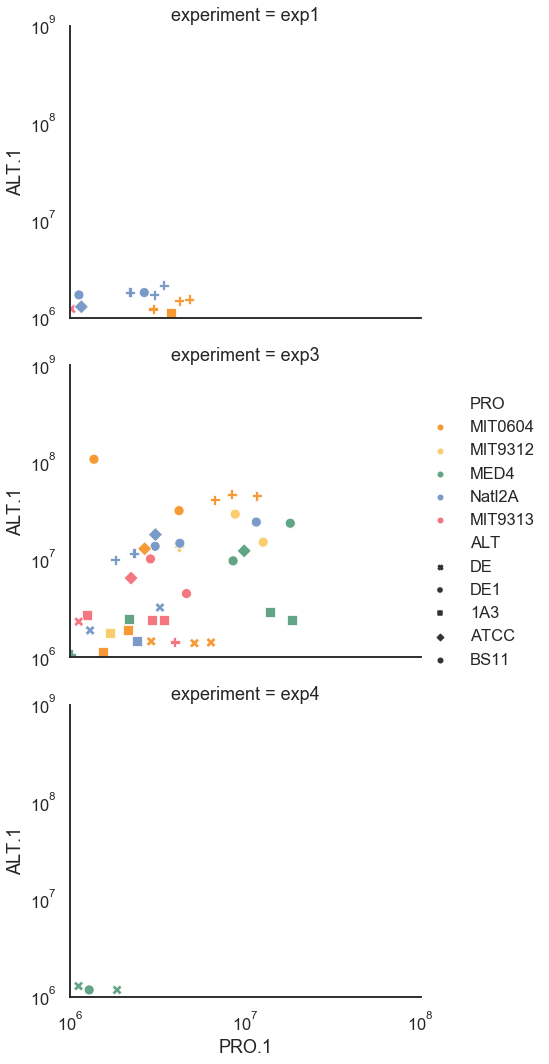

In [27]:
g =sns.relplot(data=df.loc[df['day'] == 140], 
            x='PRO.1', y='ALT.1', #col='day', 
            row='experiment', hue='PRO', style='ALT', s=100,
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers, aspect=1.3
               
           )
g.set(yscale='log')
g.set(xscale='log')

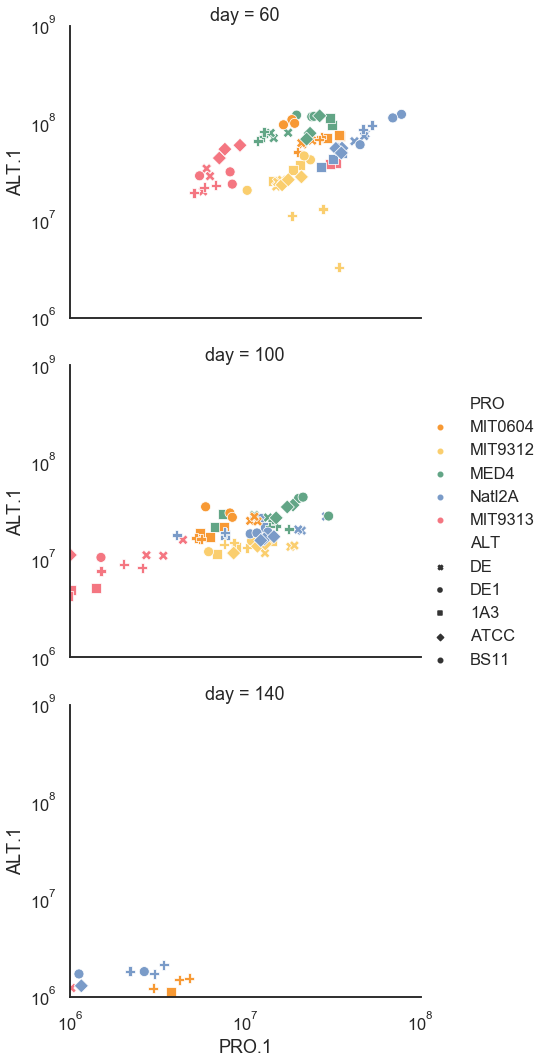

In [28]:
g =sns.relplot(data=df.loc[df['experiment'] == 'exp1'], 
            x='PRO.1', y='ALT.1', #col='day', 
            row='day', hue='PRO', style='ALT', s=100,
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers, aspect=1.3
               
           )
g.set(yscale='log')
g.set(xscale='log')

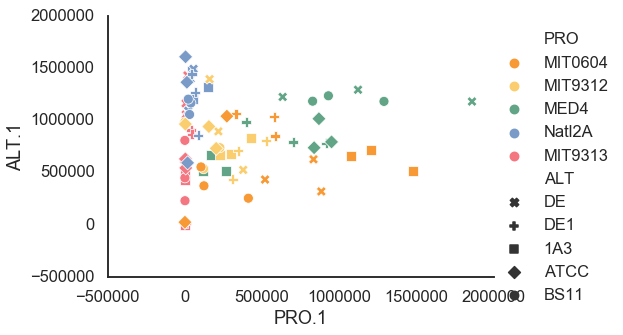

In [16]:
g =sns.relplot(data=df.loc[(df['experiment'] == 'exp4')],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
#g.set(yscale='log')
#g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

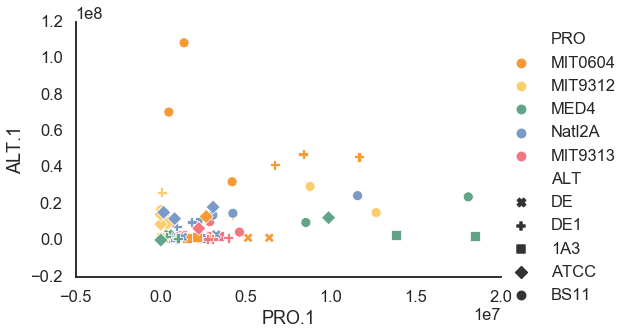

In [26]:
g =sns.relplot(data=df.loc[(df['experiment'] == 'exp3')],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
#g.set(yscale='log')
#g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

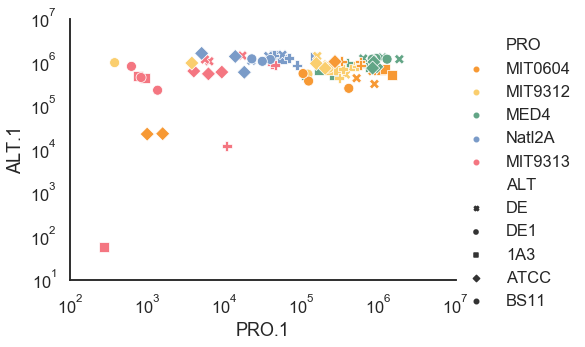

In [17]:
g =sns.relplot(data=df.loc[(df['experiment'] == 'exp4')],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
g.set(yscale='log')
g.set(xscale='log')

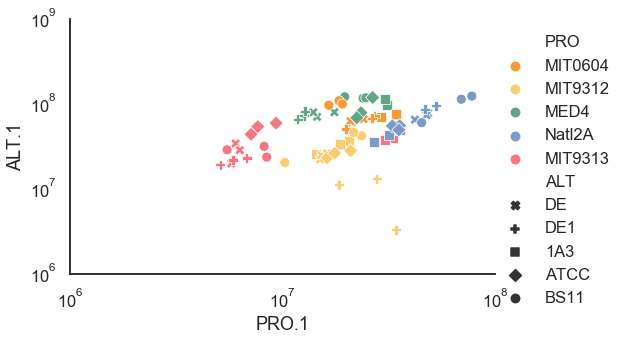

In [18]:
g =sns.relplot(data=df.loc[(df['day'] == 60)],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
g.set(yscale='log')
g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

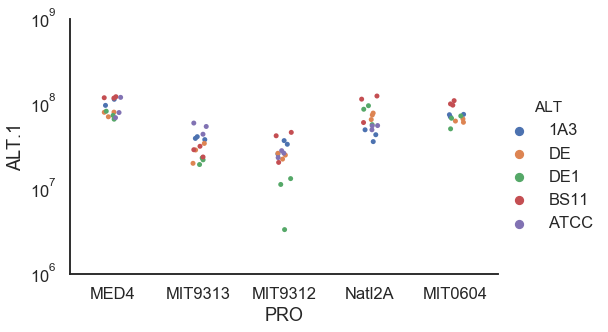

In [19]:
g =sns.catplot(data=df.loc[df.day==60], 
          x='PRO', y='ALT.1', hue='ALT', aspect=1.5)
g.set(yscale='log')


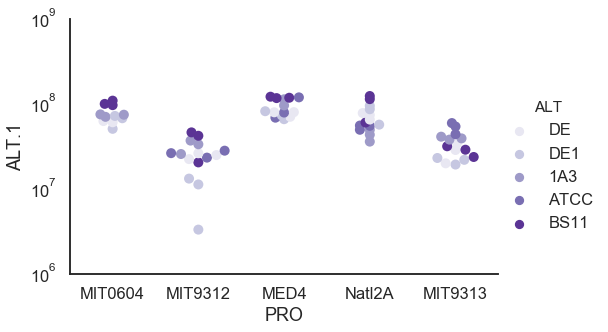

In [20]:
g =sns.catplot(data=df.loc[df.day==60], 
          x='PRO', y='ALT.1', hue='ALT', aspect=1.5,
               #palette=sns.dark_palette("purple"),
               palette='Purples',
               #palette='Greys', 
               hue_order=aorder,
               order=porder,
               kind='swarm', s=10,
              )
g.set(yscale='log')


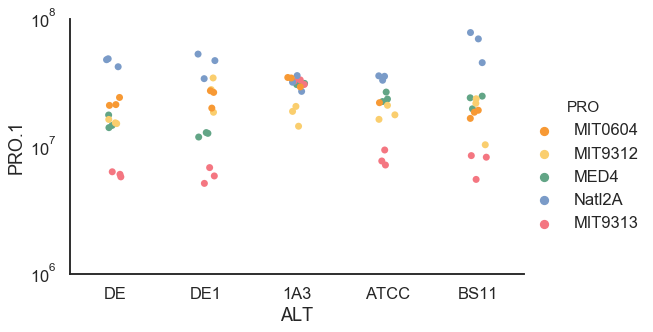

In [21]:
g = sns.catplot(data=df.loc[df.day==60], 
          x='ALT', y='PRO.1', 
                hue='PRO', 
                aspect=1.5,
                hue_order=porder,
               order=aorder,
                palette=ppallete,
                s=7,

               )
g.set(yscale='log')


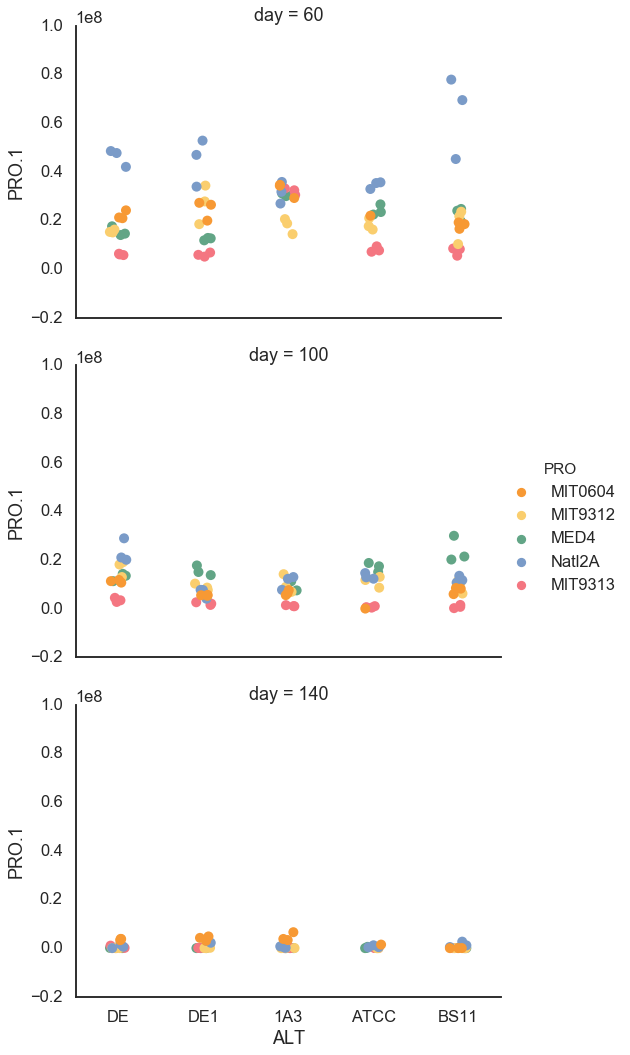

In [22]:
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='ALT', y='PRO.1', 
                hue='PRO', 
                aspect=1.5,
                hue_order=porder,
               order=aorder,
                palette=ppallete,
                s=10,
                #kind='swarm',
                row='day',
               )
#g.set(yscale='log')
#plt.ylim((1,1.5e8))
#for lh in g._legend.legendHandles: 
#    lh.set_sizes([70])

(1, 150000000.0)

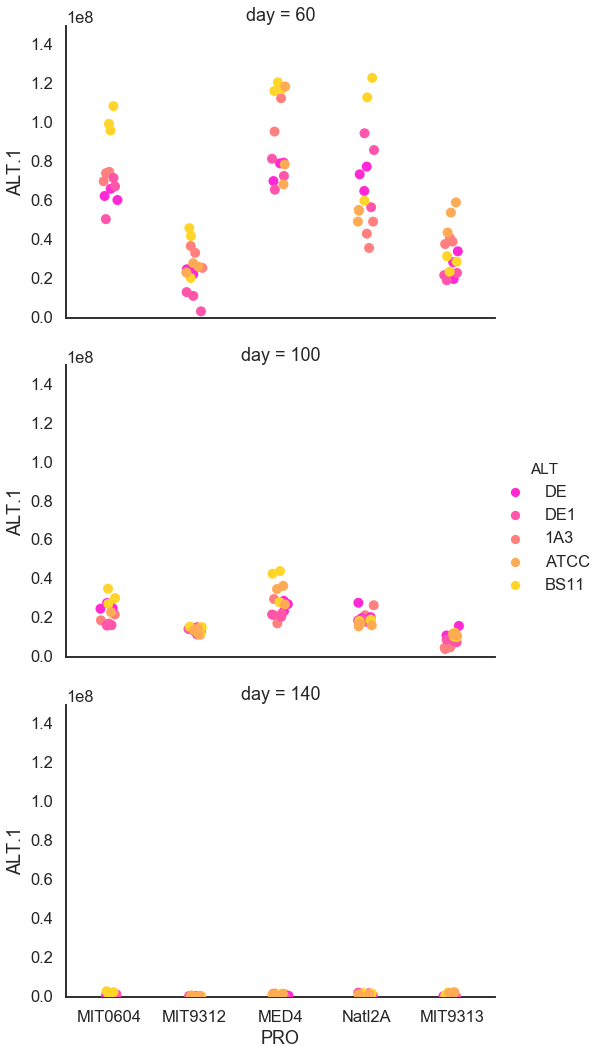

In [23]:
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='PRO', y='ALT.1', 
                hue='ALT', 
                aspect=1.5,
                hue_order=aorder,
               order=porder,
                palette=apallete,
                s=10,
                row='day',
               )
plt.ylim((1,1.5e8))
#g.set(yscale='log')
#for lh in g._legend.legendHandles: 
#    lh.set_sizes([70])

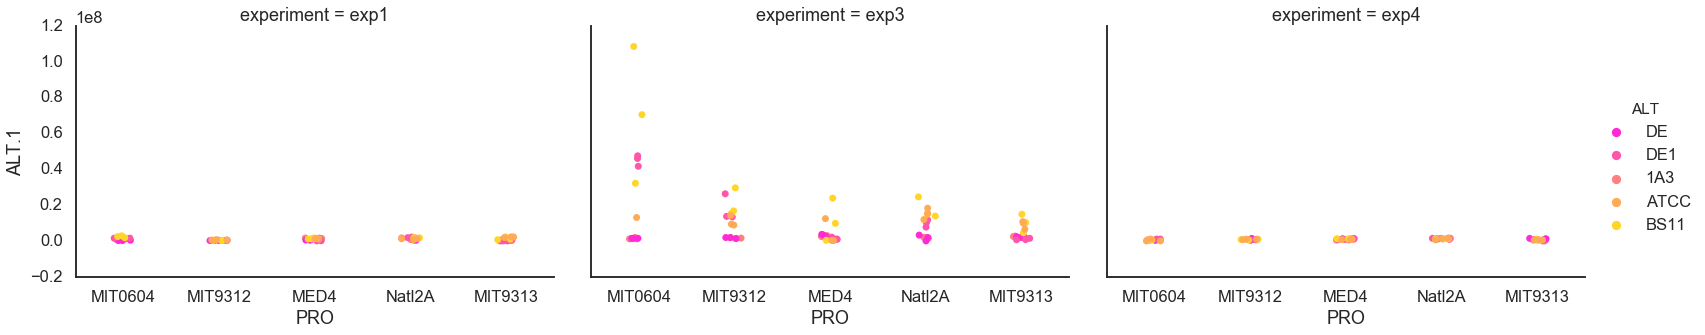

In [24]:
g = sns.catplot(data=df.loc[df.day==140], 
          x='PRO', y='ALT.1', 
                hue='ALT', 
                aspect=1.5,
                hue_order=aorder,
               order=porder,
                palette=apallete,
                s=7,
                col='experiment',
               )
#plt.ylim((1,1.5e8))
#g.set(yscale='log')
#for lh in g._legend.legendHandles: 
#    lh.set_sizes([70])